# Assignment 4: Wheres Waldo?
### Name: Eileanor LaRocco
In this assignment, you will develop an object detection algorithm to locate Waldo in a set of images. You will develop a model to detect the bounding box around Waldo. Your final task is to submit your predictions on Kaggle for evaluation.

### Imports

In [1]:
import os
import opendatasets as od
import pandas as pd
import numpy as np
import random
import csv
import matplotlib.pyplot as plt

import shutil
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image

In [2]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = device = torch.device("cuda") #mps/cuda
print(device)

cuda


### Paths

In [3]:
train_folder = "../2024-fall-ml-3-hw-4-wheres-waldo/train/train" # Original Train Images
test_folder = "../2024-fall-ml-3-hw-4-wheres-waldo/test/test" # Original Test Images
annotations_file = "../2024-fall-ml-3-hw-4-wheres-waldo/annotations.csv" # Original Annotations File
image_sz = 512

In [6]:
# Define the dataset (Train and Test Loaders)
class WaldoDataset(torch.utils.data.Dataset):
    def __init__(self, annotations_file, img_dir, transforms=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        #image = torchvision.transforms.ToTensor()(image)  # Convert to tensor
        
        box_data = self.img_labels.iloc[idx, 1:].values
        boxes = [float(item) for item in box_data]
        
        boxes = torch.as_tensor([boxes], dtype=torch.float32)
        labels = torch.ones((1,), dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((1,), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            image = self.transforms(image)

        return image, target


# Set up the dataset and data loaders
train_dataset = WaldoDataset(
    annotations_file="../2024-fall-ml-3-hw-4-wheres-waldo/train_annotations.csv",
    img_dir="../2024-fall-ml-3-hw-4-wheres-waldo/train/chunks",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_sz, image_sz)), #does this resize the bounding box too?
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

val_dataset = WaldoDataset(
    annotations_file="../2024-fall-ml-3-hw-4-wheres-waldo/test_annotations.csv",
    img_dir="../2024-fall-ml-3-hw-4-wheres-waldo/train/val",
    transforms=torchvision.transforms.Compose([
        torchvision.transforms.Resize((image_sz, image_sz)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=lambda x: list(zip(*x))
)

val_data_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    collate_fn=lambda x: list(zip(*x))
)


# Model

### Architecture

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.ops import RoIAlign
import torchvision.ops as ops

device = device = torch.device("cuda")
image_sz = 512

def decode_boxes(deltas, anchors):
    # Convert anchors to center format (cx, cy, w, h)
    anchors = ops.box_convert(anchors, in_fmt="xyxy", out_fmt="cxcywh")
    anchor_cx, anchor_cy, anchor_w, anchor_h = anchors.split(1, dim=1)

    # Decode deltas
    dx, dy, dw, dh = deltas.split(1, dim=1)
    pred_cx = dx * anchor_w + anchor_cx
    pred_cy = dy * anchor_h + anchor_cy
    pred_w = torch.exp(dw) * anchor_w
    pred_h = torch.exp(dh) * anchor_h

    # Convert back to (x1, y1, x2, y2)
    decoded_boxes = torch.cat([
        pred_cx - 0.5 * pred_w,  # x1
        pred_cy - 0.5 * pred_h,  # y1
        pred_cx + 0.5 * pred_w,  # x2
        pred_cy + 0.5 * pred_h   # y2
    ], dim=1)

    return decoded_boxes


def generate_anchors(base_size, scales, aspect_ratios, feature_size, stride, device):
    anchors = []
    for y in range(feature_size[0]):
        for x in range(feature_size[1]):
            cx = x * stride + stride / 2  # Center x
            cy = y * stride + stride / 2  # Center y
            for scale in scales:
                for ratio in aspect_ratios:
                    w = base_size * scale * (ratio ** 0.5)
                    h = base_size * scale / (ratio ** 0.5)
                    anchors.append([cx - w / 2, cy - h / 2, cx + w / 2, cy + h / 2])
    anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
    return anchors


def generate_proposals(rpn_cls_logits, rpn_bbox_preds, anchors, image_size, device, top_n=1):
    batch_size = rpn_cls_logits.size(0)
    proposals = []

    for b in range(batch_size):
        # Flatten predictions and anchors
        cls_logits = rpn_cls_logits[b].permute(1, 2, 0).reshape(-1, 2)
        bbox_preds = rpn_bbox_preds[b].permute(1, 2, 0).reshape(-1, 4)
        
        # Apply softmax to classification logits
        scores = F.softmax(cls_logits, dim=-1)[:, 1] 
        
        # Decode predicted deltas to proposals
        decoded_boxes = decode_boxes(bbox_preds, anchors)
        
        # Clip proposals to image boundaries
        decoded_boxes = ops.clip_boxes_to_image(decoded_boxes, image_size)
        
        # Filter proposals by score and apply NMS
        keep = ops.nms(decoded_boxes, scores, iou_threshold=0.7)
        keep = keep[:top_n]  # Keep top_n proposals (1 in this case)
        
        # Add batch index
        batch_proposals = torch.cat(
            [torch.full((len(keep), 1), b, dtype=torch.float32, device=decoded_boxes.device), 
             decoded_boxes[keep]], 
            dim=1
        )
        proposals.append(batch_proposals)

    # Concatenate all proposals across batches
    return torch.cat(proposals, dim=0)


class SimpleRCNN(nn.Module):
    def __init__(self, num_anchors=9):
        super(SimpleRCNN, self).__init__()
        
        # Use pretrained ResNet50 as the backbone
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Use layers up to the last conv layer
        
        # Freeze the initial layers to retain pretrained weights
        for param in list(self.backbone.parameters())[:2]:  # Freeze less
            param.requires_grad = False

        # Region Proposal Network (RPN)
        self.rpn_conv = nn.Conv2d(2048, 512, kernel_size=3, padding=1)  # RPN Conv layer
        self.rpn_cls = nn.Conv2d(512, num_anchors * 2, kernel_size=1)  # 2 class logits per anchor (object, no object)
        self.rpn_reg = nn.Conv2d(512, num_anchors * 4, kernel_size=1)  # 4 bbox coords per anchor

        # RoI Align (assumes a fixed feature map size of 7x7 for simplicity)
        self.roi_align = RoIAlign((7, 7), spatial_scale=1.0 / 16, sampling_ratio=2)

        # Fully connected layers for classification and regression
        self.fc1 = nn.Linear(2048 * 7 * 7, 1024)
        self.fc2 = nn.Linear(1024, 4)  # Output bbox coords (x, y, w, h)

    def forward(self, x):
        # Extract features
        features = self.backbone(x)

        # Generate RPN outputs
        rpn_feat = F.relu(self.rpn_conv(features))
        rpn_cls_logits = self.rpn_cls(rpn_feat)
        rpn_bbox_preds = self.rpn_reg(rpn_feat)

        # Generate anchors
        feature_size = (features.size(2), features.size(3))  # (height, width) of feature map
        stride = 16  # Assuming input image is downsampled by 16x in the backbone
        anchors = generate_anchors(base_size=16, scales=[1.0, 2.0, 0.5], aspect_ratios=[0.5, 1.0, 2.0],
                                    feature_size=feature_size, stride=stride, device=x.device)

        # Generate proposals from RPN outputs
        proposals = generate_proposals(rpn_cls_logits, rpn_bbox_preds, anchors, x.size()[2:], device=x.device, top_n=1)

        # Perform RoI Align
        roi_features = self.roi_align(features, proposals)

        # Predict bounding boxes
        roi_flattened = roi_features.view(roi_features.size(0), -1)
        fc1_out = F.relu(self.fc1(roi_flattened))
        bbox = self.fc2(fc1_out)

        return bbox


# Example usage:
# Instantiate the model
model = SimpleRCNN()

# Example input image tensor (batch_size=1, channels=3, height=512, width=512)
input_tensor = torch.randn(1, 3, 512, 512)

# Move inputs to the same device as the model
model = model.to(device)
input_tensor = input_tensor.to(device)

# Forward pass
bbox = model(input_tensor)

print("BBox Refinements:", bbox.shape)
print(bbox)


BBox Refinements: torch.Size([1, 4])
tensor([[0.2031, 0.0948, 0.0462, 0.1849]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


### Training

In [17]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn


def calculate_iou(pred_boxes, target_boxes):
    """
    Compute IoU between predicted and target bounding boxes.
    Args:
        pred_boxes: Tensor of shape (N, 4) with predicted boxes (x_min, y_min, x_max, y_max).
        target_boxes: Tensor of shape (N, 4) with ground truth boxes (x_min, y_min, x_max, y_max).
    Returns:
        IoU: Tensor of shape (N,) with IoU scores for each box.
    """
    # Resize Target Boxes
    target_boxes = target_boxes.squeeze(1)

    # Calculate intersection
    x_min_inter = torch.max(pred_boxes[:, 0], target_boxes[:, 0])
    y_min_inter = torch.max(pred_boxes[:, 1], target_boxes[:, 1])
    x_max_inter = torch.min(pred_boxes[:, 2], target_boxes[:, 2])
    y_max_inter = torch.min(pred_boxes[:, 3], target_boxes[:, 3])

    inter_area = torch.clamp(x_max_inter - x_min_inter, min=0) * torch.clamp(y_max_inter - y_min_inter, min=0)

    # Calculate union
    pred_area = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    target_area = (target_boxes[:, 2] - target_boxes[:, 0]) * (target_boxes[:, 3] - target_boxes[:, 1])
    union_area = pred_area + target_area - inter_area

    # Compute IoU
    iou = inter_area / torch.clamp(union_area, min=1e-6)  # Avoid division by zero
    return iou


def train(model, train_data_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    for images, targets in train_data_loader:
        
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
        
        # Extract bounding boxes from targets
        target_boxes = torch.stack([target["boxes"] for target in targets]).squeeze(1)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(torch.stack(images))

        # Calculate the loss
        loss = criterion(outputs, target_boxes)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()

        # Calculate IoU
        iou = calculate_iou(outputs, target_boxes)
        total_iou += iou.sum().item()
        num_samples += len(target_boxes)

    avg_loss = running_loss / len(train_data_loader)
    avg_iou = total_iou / num_samples

    #print(f"Training Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")


def evaluate(model, val_data_loader, criterion, checkpoint_path):
    model.eval()
    total_loss = 0.0
    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for images, targets in val_data_loader:
            
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
            
            # Extract bounding boxes from targets
            target_boxes = torch.stack([target["boxes"] for target in targets]).squeeze(1)

            # Forward pass
            outputs = model(torch.stack(images))

            # Calculate the loss
            loss = criterion(outputs, target_boxes)
            total_loss += loss.item()

            # Calculate IoU
            iou = calculate_iou(outputs, target_boxes)
            total_iou += iou.sum().item()
            num_samples += len(target_boxes)

    avg_loss = total_loss / len(val_data_loader)
    avg_iou = total_iou / num_samples
    

    #print(f"Evaluation Loss: {avg_loss:.4f}, IoU: {avg_iou:.4f}")
    return avg_iou
    
    
# Set up the model, loss, and optimizer
model = SimpleRCNN().to(device)
criterion = nn.L1Loss()  # L1 loss for bounding box regression
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
checkpoint_path = "../2024-fall-ml-3-hw-4-wheres-waldo/outputs/best_model.pth"
num_epochs = 100
best_iou = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    
    # Train the model
    train(model, train_data_loader, criterion, optimizer)

    # Evaluate the model
    avg_iou = evaluate(model, val_data_loader, criterion, checkpoint_path)
    
    #Scheduler
    scheduler.step()
    
    # Save the best model
    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Best model saved with IoU: {best_iou:.4f}")



Epoch 1/100
Epoch 2/100
Best model saved with IoU: 0.0040
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Best model saved with IoU: 0.0049
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Best model saved with IoU: 0.0060
Epoch 14/100
Epoch 15/100
Epoch 16/100
Best model saved with IoU: 0.0064
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Best model saved with IoU: 0.0070
Epoch 21/100
Epoch 22/100
Best model saved with IoU: 0.0150
Epoch 23/100
Best model saved with IoU: 0.0250
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Best model saved with IoU: 0.0265
Epoch 30/100
Epoch 31/100
Best model saved with IoU: 0.0268
Epoch 32/100
Epoch 33/100
Best model saved with IoU: 0.0271
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Best model saved with IoU: 0.0366
Epoch 44/100
Epoch 45/100
Best model saved with IoU: 0.0369
Epoch 46/100
Bes

# Submission File 

/tmp/ipykernel_559654/803872727.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../2024-fall-ml-3-hw-4-wheres-waldo/outputs/best_model.

Predicted Bounding Box: [317.7287  327.75156 331.76993 357.8577 ]


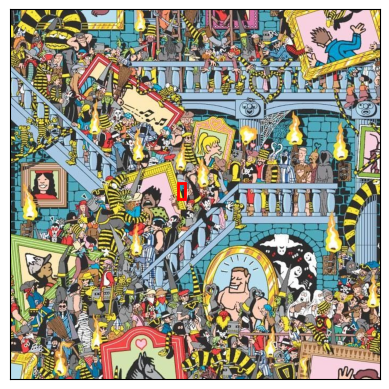

Predicted Bounding Box: [313.6819  305.54834 375.94388 335.3838 ]


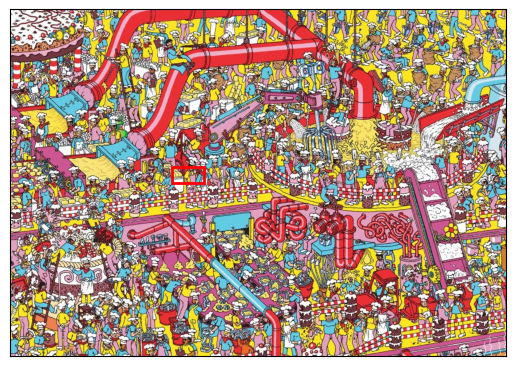

Predicted Bounding Box: [184.08894 324.63498 204.29295 357.18195]


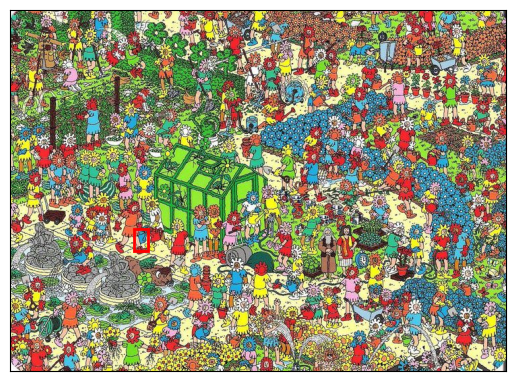

Predicted Bounding Box: [283.93048 461.83072 296.86987 478.4907 ]


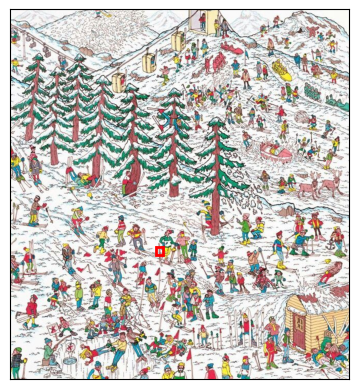

Predicted Bounding Box: [670.6129 675.0686 751.9296 711.1657]


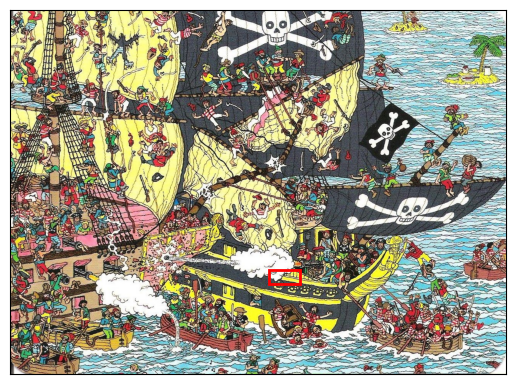

Predicted Bounding Box: [ 883.85046  928.5506  1009.0073   986.69794]


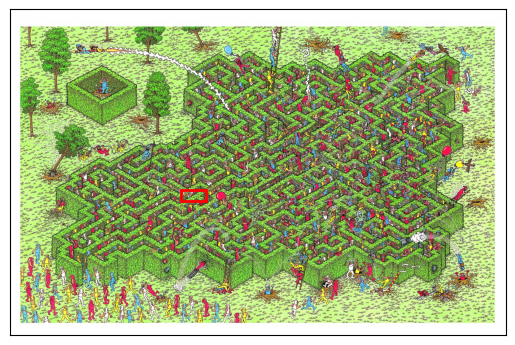

Predicted Bounding Box: [509.78528 167.79976 562.1829  223.56627]


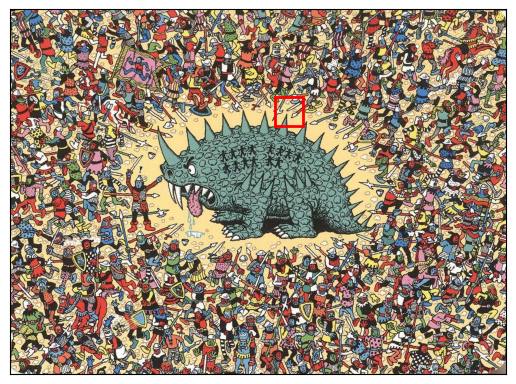

Predicted Bounding Box: [382.30966 396.852   437.17044 443.4783 ]


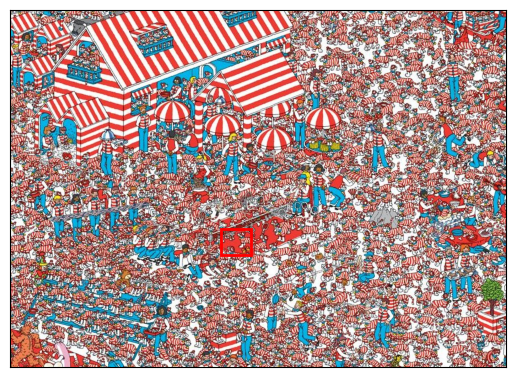

Predicted Bounding Box: [654.9904  762.18097 749.4361  815.674  ]


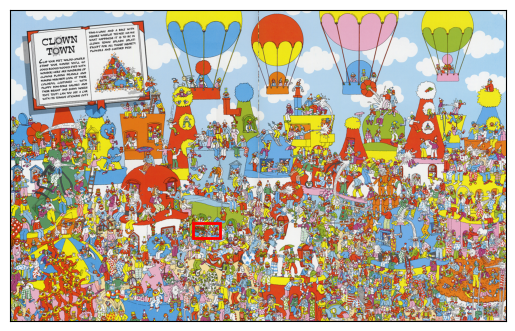

In [18]:
predictions = []

output_directory = "../2024-fall-ml-3-hw-4-wheres-waldo/outputs"
if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        
#Load saved best model
model = SimpleRCNN().to(device)
model.load_state_dict(torch.load('../2024-fall-ml-3-hw-4-wheres-waldo/outputs/best_model.pth'))

# Function to predict bounding box on a new image
def predict(model, image_path, transform=None):
    model.eval()  # Set the model to evaluation mode

    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")  # Open image and convert to RGB
    orig_width, orig_height = image.size  # Get original image dimensions
    if transform:
        image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension

    # Ensure image is a Tensor and move it to the correct device
    image = image.to(device)

    # Predict the bounding box
    with torch.no_grad():
        predicted_bbox = model(image).squeeze().cpu().numpy()

    # Scale bbox back to original image dimensions
    predicted_bbox[0] *= orig_width / image_sz  # x_min
    predicted_bbox[1] *= orig_height / image_sz  # y_min
    predicted_bbox[2] *= orig_width / image_sz  # x_max
    predicted_bbox[3] *= orig_height / image_sz  # y_max

    return predicted_bbox


# Define image transformations (resize, normalization)
transform = transforms.Compose([
    transforms.Resize((image_sz, image_sz)),  # Resize the image to 512x512
    transforms.ToTensor(),  # Convert the image to a tensor
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#For each image in test folder, predict, draw bounding box, save image, and save into csv file for submission
test_images = [img for img in os.listdir(test_folder) if img.endswith(".jpg")]
predictions = []

for name in test_images:
    image_path = os.path.join(test_folder, name) 
    predicted_bbox = predict(model, image_path, transform)

    # Print the predicted bounding box (x_min, y_min, x_max, y_max)
    print("Predicted Bounding Box:", predicted_bbox)

    # Plot the image and the predicted bounding box
    image = Image.open(image_path)
    plt.imshow(image)
    plt.gca().add_patch(plt.Rectangle(
        (predicted_bbox[0], predicted_bbox[1]),  # (x_min, y_min)
        predicted_bbox[2] - predicted_bbox[0],  # Width (x_max - x_min)
        predicted_bbox[3] - predicted_bbox[1],  # Height (y_max - y_min)
        linewidth=2, edgecolor='r', facecolor='none'
    ))
    plt.xticks([])
    plt.yticks([])
    plt.savefig(os.path.join(output_directory, name), bbox_inches='tight')
    plt.show()

    # Extract bounding box coordinates
    x_min, y_min, x_max, y_max = predicted_bbox
    predictions.append([name, x_min, y_min, x_max, y_max])

# Save predictions to CSV
df = pd.DataFrame(predictions, columns=["filename", "xmin", "ymin", "xmax", "ymax"])
df.to_csv(os.path.join(output_directory, 'predictions.csv'), index=False)
